# Ensemble Regression for Predicting Wages
This notebook explores using scikit-learn's `VotingRegressor` to predict the `wage` of individuals in the Census (1994) dataset from OpenML. We compare ensemble performance against individual regressors.

In [9]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
%matplotlib inline

## 1. Load and Inspect Data

In [10]:
data = fetch_openml(data_id=534, as_frame=True).frame
data.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


In [11]:
#data = fetch_openml(name='census', version=1, as_frame=True)
data = fetch_openml(data_id=534, as_frame=True).frame
data.head()
df = data.copy()
y = df['WAGE']
X = df.drop(columns=['WAGE'])
print('Shape:', X.shape)
print(y.describe())

Shape: (534, 10)
count    534.000000
mean       9.024064
std        5.139097
min        1.000000
25%        5.250000
50%        7.780000
75%       11.250000
max       44.500000
Name: WAGE, dtype: float64


## 2. Preprocessing Pipeline

In [12]:
categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 3. Define and Evaluate Individual Regressors

In [13]:
models = {
    'lr': Pipeline([('pre', preprocessor), ('model', LinearRegression())]),
    'ridge': Pipeline([('pre', preprocessor), ('model', Ridge(random_state=42))]),
    'knn': Pipeline([('pre', preprocessor), ('model', KNeighborsRegressor())]),
    'dt': Pipeline([('pre', preprocessor), ('model', DecisionTreeRegressor(random_state=42))]),
    'svr': Pipeline([('pre', preprocessor), ('model', SVR())])
}
results = []
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results.append((name, mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)))
results_df = pd.DataFrame(results, columns=['Model','MSE','R2'])
display(results_df)

,Model,MSE,R2
0,lr,19.502597,0.388221
1,ridge,19.504598,0.388158
2,knn,19.935323,0.374647
3,dt,56.160043,-0.761690
4,svr,20.983530,0.341766


## 4. Voting Regressor Ensemble

In [14]:
estimators = [(name, pipe) for name, pipe in models.items()]
voting = VotingRegressor(estimators=estimators)
voting.fit(X_train, y_train)
y_pred_ens = voting.predict(X_test)
print('Ensemble MSE:', mean_squared_error(y_test, y_pred_ens))
print('Ensemble R2 :', r2_score(y_test, y_pred_ens))

Ensemble MSE: 21.081321023148426
Ensemble R2 : 0.33869808877183416


## 5. Tuning Ensemble Weights

In [15]:
param_grid = {'weights': [[1,1,1,1,1], [2,1,1,1,1], [1,2,1,1,1], [1,1,2,1,1], [1,1,1,2,1], [1,1,1,1,2]]}
grid = GridSearchCV(VotingRegressor(estimators=estimators), param_grid, cv=3, scoring='r2')
grid.fit(X_train, y_train)
print('Best Weights:', grid.best_params_)
best_ens = grid.best_estimator_
y_pred_best = best_ens.predict(X_test)
print('Tuned Ensemble MSE:', mean_squared_error(y_test, y_pred_best))
print('Tuned Ensemble R2 :', r2_score(y_test, y_pred_best))

Best Weights: {'weights': [1, 2, 1, 1, 1]}
Tuned Ensemble MSE: 20.58946928648696
Tuned Ensemble R2 : 0.35412703144283497


## 6. Feature Importance via Permutation Importance

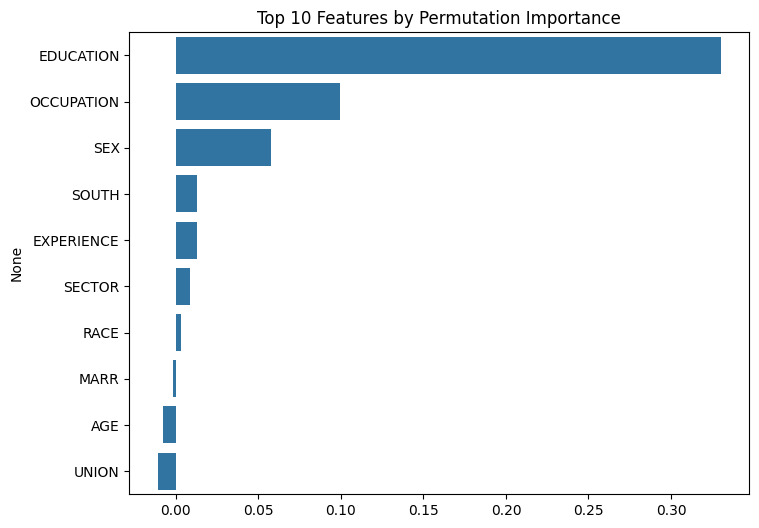

In [16]:
perm = permutation_importance(best_ens, X_test, y_test, n_repeats=10, random_state=42)
importances = pd.Series(perm.importances_mean, index=X_test.columns)
top_imp = importances.sort_values(ascending=False).head(10)
plt.figure(figsize=(8,6))
sns.barplot(x=top_imp.values, y=top_imp.index)
plt.title('Top 10 Features by Permutation Importance')
plt.show()